# Steady-state heat diffusion in 1D cylindrical mesh

MW 230817, 240503

This example will evaluate the analytic solution for a simple steady-state heat transfer problem, and use PyFVTool to solve the same problem by the finite-volume method.

In [1]:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt

In [2]:
# explicity import all required routines from pyfvtool
from pyfvtool import CylindricalGrid1D
from pyfvtool import CellVariable
from pyfvtool import transientTerm, diffusionTerm
from pyfvtool import harmonicMean
from pyfvtool import constantSourceTerm
from pyfvtool import solvePDE

## Problem statement

The steady-state heat equation in 1D cylindrical geometry (total cylinder radius $R$), with an internal heat source (strength $S$) and Dirichlet (constant-value) outer boundary. This can model, for example the temperature (temperature $T$ relative to outer temperature) profile in a electrically resistive wire through which a current passes.

$$ 0 = k \nabla^2 T + S $$ 

which, under the circumstances mentioned above, should have solution

$$ T(r) = \frac{S}{4k} (R^2 - r^2) $$

*Do not forget that we are in cylindrical coordinates and that $\nabla^2$ has the corresponding form.*


## System parameters

It is possibly wise to not set all parameters to 1 or even integer values for testing purposes but rather use something else.

In [3]:
R = 2.1
k_val = 3.7 # heat transfer coefficient
S_val = 4.2 # source strength
T_outer = 0.0  # (outer) boundary temperature

## Finite-volume solution with PyFVTool

Define 1D cylindrical grid with radius $R$.

In [4]:
Nr = 50
Lr = R

In [5]:
mesh = CylindricalGrid1D(Nr, Lr)

Create coefficients of diffusion and source terms in the form of `CellVariable`s.

In [6]:
k = CellVariable(mesh, k_val) # heat transfer coefficient

In [7]:
S = CellVariable(mesh, S_val)

Create solution variable `T`, initialize to arbitrary 0.0 value.

Subsequently, specify a boundary condition for this variable: outer wall will be kept at 0.0. (Dirichlet boundary condition).

In [8]:
T = CellVariable(mesh, 0.0)

In [9]:
# switch the right (=outer) boundary to Dirichlet: fixed temperature
T.BCs.right.a[:] = 0.0
T.BCs.right.b[:] = 1.0
T.BCs.right.c[:] = T_outer
T.apply_BCs()

The diffusion term requires the face values of the diffusion coefficient

In [10]:
k_face = harmonicMean(k)

The equation is defined as a list of the different matrix equation terms.

In [11]:
eqnterms = [-diffusionTerm(k_face),
             constantSourceTerm(S)]

Go solve. Since no transient term is part of the equation, this will yield directly the steady-state solution.

In [12]:
solvePDE(T, eqnterms);

Retrieve solution temperature profile from solution `CellVariable`.

In [13]:
rnum, Tnum = T.plotprofile()

## Comparison with the analytic solution

In [14]:
r_an = np.linspace(0, R)
T_an = (S_val/(4*k_val))*(R**2 - r_an**2)

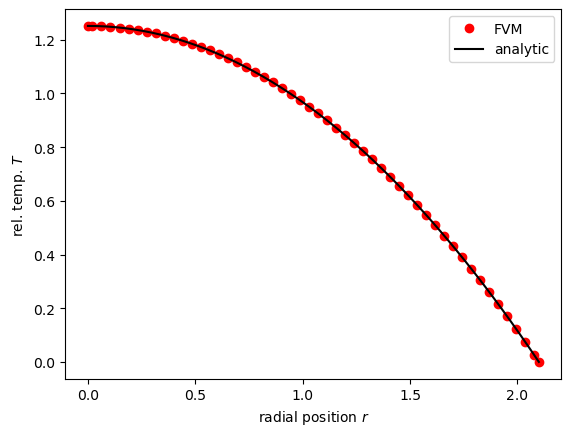

In [15]:
plt.plot(rnum, Tnum, 'ro', label='FVM')
plt.plot(r_an, T_an, 'k', label='analytic')
plt.ylabel('rel. temp. $T$')
plt.xlabel('radial position $r$')
plt.legend(); # semicolon avoids output of '<matplotlib.legend.Legend...>' descriptor

### Quantitative testing of agreement between FV result and analytic solution

The tolerance is manually tuned. This should help detect code changes that break good agreement with experiment and theory.

In [16]:
# analytic solution evaluated at cell positions
T_an_rnum = (S_val/(4*k_val))*(R**2 - rnum**2)

In [17]:
# normalized error
norm_err = (Tnum-T_an_rnum)/T_an_rnum.max() 

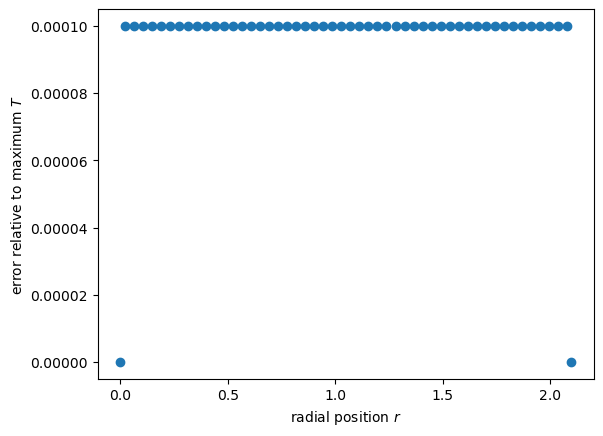

In [18]:
plt.plot(rnum, norm_err, 'o')
plt.ylabel('error relative to maximum $T$')
plt.xlabel('radial position $r$');

In [19]:
print(np.abs(norm_err) < 0.0001)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False  True]


In [20]:
assert np.all(np.abs(norm_err) < 0.001)